In [1]:
import pandas as pd
import numpy as np 
import sys
sys.path.append('../Function')
import function
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Dropout
from keras.models import Sequential


In [2]:
df = pd.read_excel('../../site_info_ver_5.xlsx')

In [3]:

df = df.drop(['Total','Tourists_Count'],axis=1)
df = df.drop(df.filter(regex='nox').columns, axis=1)
df = df.drop(df.filter(regex='so2').columns, axis=1)
df = df.drop(df.filter(regex='pm2.5').columns, axis=1)
df = df.drop(df.filter(regex='Ashkelon').columns, axis=1)


In [4]:
dataset = df.copy()
sites = dataset.Site_Name.unique()
site_name = 'The Masada'
target = 'Israelis_Count'
target_title = 'Israelis'
dataset = dataset.loc[dataset.Site_Name==site_name]


print('model on site',site_name)
print('Focus on ',target_title)


# dataset = function.remove_outliers(dataset, target)
dataset = function.remove_unique_one(dataset)
dataset = function.split_date(dataset)
dataset = function.get_weekday(dataset)
dataset = function.last_year_entries_info(dataset,target)
dataset.drop("Date",axis=1,inplace=True)
dataset = dataset.astype({'month': 'category'})
dataset = dataset.drop('day', axis=1)
dataset = dataset.drop('year', axis=1)


dataset = pd.get_dummies(dataset)
dataset = function.remove_high_corr(dataset, target,0.4)

print('features', dataset.dtypes)
print('shape of dataset',dataset.shape)
dataset[['Israelis_Count']].describe()

model on site The Masada
Focus on  Israelis
Add Last year visitors Successfully
features operations                       int64
is_jewish_holiday                int64
is_muslims_holiday               int64
pm10                           float64
Tel_Aviv-Yafo_pm10_exceeded      int64
Season_autumn                    int64
Season_spring                    int64
Season_summer                    int64
Friday                           uint8
Monday                           uint8
Sunday                           uint8
Thursday                         uint8
Tuesday                          uint8
Wednesday                        uint8
Last_year_visitors             float64
month_1                          uint8
Israelis_Count                   int64
dtype: object
shape of dataset (1495, 17)


,Israelis_Count
count,1495.000000
mean,1577.650836
std,790.851670
min,61.000000
25%,959.000000
50%,1446.000000
75%,2106.500000
max,3982.000000


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X = dataset.drop(target,axis=1)
y = dataset[target]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=312148513)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train)
X_test_scaled = X_test_scaler.fit_transform(X_test)

y_train_scaled = np.log(y_train+0.001)
y_test_scaled = np.log(y_test+0.001)

dataset_train = pd.merge(left=X_train, right=y_train, left_index=True, right_index=True)
dataset_test = pd.merge(left=X_test, right=y_test, left_index=True, right_index=True)



STDs

In [6]:
print("train STD " + str(np.std(y_train)))
print("test STD " + str(np.std(y_test)))

train STD 792.9475515905618
test STD 779.7309992145478



mae 516.2382193983199
rmse 660.7639815944075
std 779.7309992145478


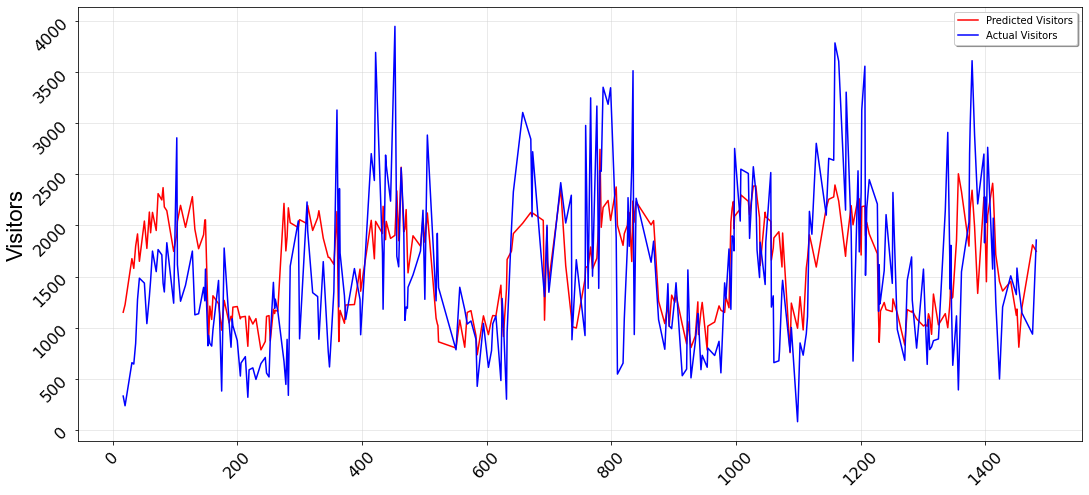

,Prediction,Actual
17,1150.622070,330
20,1223.790039,235
31,1675.377319,657
34,1579.531616,643
37,1796.792847,845
40,1917.252563,1275
43,1648.935913,1484
51,2043.185913,1436
55,1775.262817,1039
59,2131.381836,1304


In [37]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2


# create NN model
model = Sequential()
 
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1],activation='relu',activity_regularizer=l2(0.01)))

model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))

model.add(Dense(8,activation='relu',activity_regularizer=l2(0.01)))

model.add(Dense(2,activity_regularizer=l2(0.01)))
model.add(Dense(1))
 
# Compiling the model
model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=25, verbose=1 )
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0 )
mcp = ModelCheckpoint(filepath='weights_Masada.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=1000,verbose=0 ,callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=4)
clear_output(True)
model.load_weights('weights_Masada.h5')
prediction =model.predict(X_test_scaled)
print('')
res2 = pd.DataFrame(
    data={
        'Prediction':prediction.T[0],
        'Actual': y_test.values
    },
    index=y_test.index
)
print('mae', mean_absolute_error(res2.Prediction, res2.Actual))
print('rmse',function.get_rmse(res2.Prediction, res2.Actual))
print('std',np.std(res2.Actual))

res2.sort_index(inplace=True)
function.plot_line(res2.Prediction, res2.Actual)
# function.plot_residuals(res2.Prediction, res2.Actual)
res2.head(10)

In [38]:
rmse_str = str(np.round(function.get_rmse(res2.Prediction, res2.Actual),2))
import os 
# Check whether the specified path exists or not
path = site_name+'/'+rmse_str
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)
model.save(path)

INFO:tensorflow:Assets written to: The Masada/660.76\assets


NN Train & Test

In [39]:
from lime_stability.stability import LimeTabularExplainerOvr
from keras.models import load_model
# model = load_model('./The Masada/588.77')

#Train
prediction =model.predict(X_train_scaled)
print('')
res2 = pd.DataFrame(
    data={
        'Prediction':prediction.T[0],
        'Actual': y_train.values
    },
    index=y_train.index
)
print('mae train', mean_absolute_error(res2.Prediction, res2.Actual))
print('rmse train',function.get_rmse(res2.Prediction, res2.Actual))
print('std train',np.std(res2.Actual))

#Test
prediction =model.predict(X_test_scaled)
print('')
res2 = pd.DataFrame(
    data={
        'Prediction':prediction.T[0],
        'Actual': y_test.values
    },
    index=y_test.index
)
print('mae test', mean_absolute_error(res2.Prediction, res2.Actual))
print('rmse test',function.get_rmse(res2.Prediction, res2.Actual))
print('std test',np.std(res2.Actual))


mae train 493.97587039398906
rmse train 621.9041948399349
std train 792.9475515905618

mae test 516.2382193983199
rmse test 660.7639815944075
std test 779.7309992145478


Interperating the model via LIME

(16,)
(14,)
(1196, 16)
Intercept 1508.0165202602695
Prediction_local [1169.88302605]
Right: 1152.0154


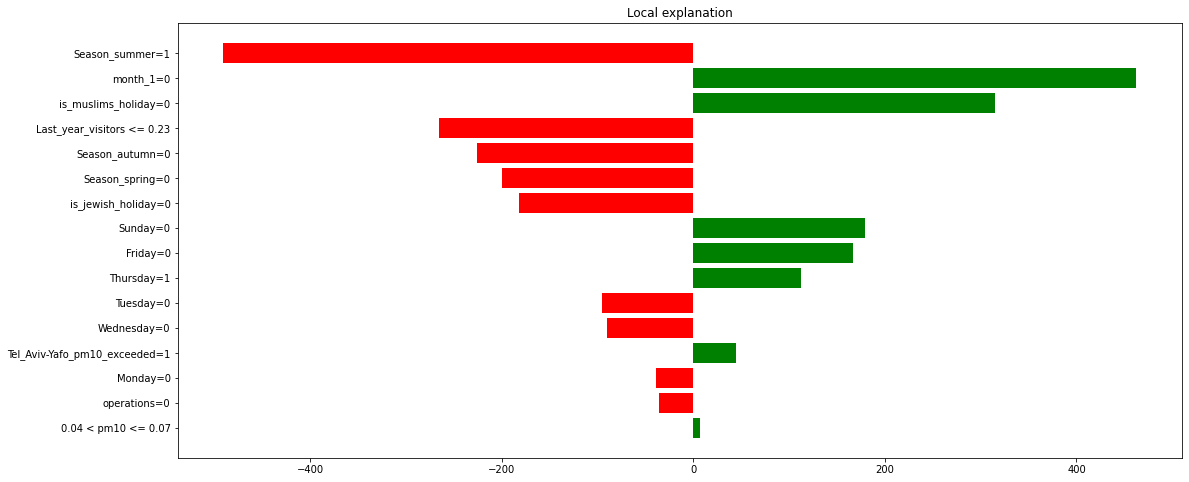

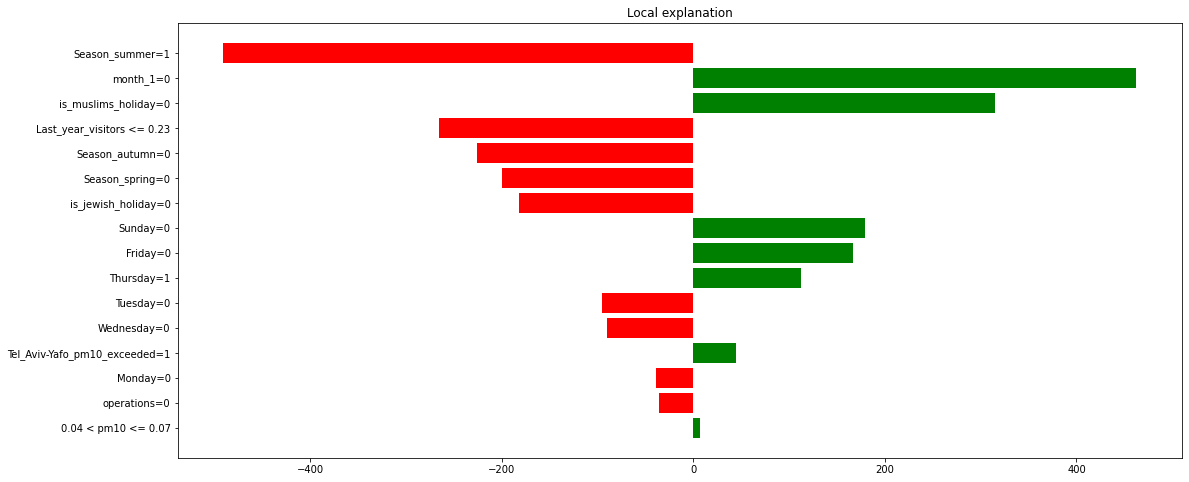

In [40]:
class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train.values[:,x]))
    for x in range(X_train.shape[1])]) <= 10).flatten()
print(X_train.columns.shape)
print(categorical_features.shape)
print(X_train.shape)
explainer = LimeTabularExplainerOvr(X_train_scaled,
 feature_names=X_train.columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True, mode='regression',feature_selection='auto' )

exp = explainer.explain_instance(X_test_scaled[np.random.randint(0,len(X_test_scaled))],model.predict,num_features=200)
exp.show_in_notebook(show_table=True)
exp.as_pyplot_figure()
